In [123]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492

In [4]:
cali_df = pd.read_csv(cali_housing_path)

In [5]:
print(cali_df.head())

   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         735501.806984         67432.5170

In [6]:
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [43]:
subset_indices = np.random.choice(X_train.index, size=len(X_train), replace=False)
print(subset_indices)
X_train_subset = X_train.loc[subset_indices]
y_train_subset = y_train.loc[subset_indices]
print(X_train_subset.head())
print(y_train_subset.head())

[15049 12568 12860 ... 15802   591 12730]
       Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  \
15049         4.0625          48       2015           356        1020   
12568         2.5954          47       2403           517        1144   
12860         7.0897          52       1389           191         514   
11299         2.6048          17       2863           665         715   
4539          3.1196          16       3311           702        1627   

       Households  Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
15049         338     33.96    -118.31       13656.731428    11939.653265   
12568         455     36.98    -122.01       12366.089126   471280.367986   
12860         202     37.86    -122.25        8377.321293   556025.107891   
11299         467     33.02    -117.07       20135.412209   158136.524917   
4539          624     32.84    -116.76       32631.382446   192658.787002   

       Distance_to_SanDiego  Distance_to_SanJose  Distan

In [44]:
X_train_subset = X_train_subset.reset_index(drop=True)
y_train_subset = y_train_subset.reset_index(drop=True)

In [50]:
X_train_tensor = tf.constant(X_train_subset.values, dtype=tf.float32)
y_train_tensor = tf.constant(y_train_subset.values, dtype=tf.float32)
print(y_train_tensor.shape)

(16512, 1)


In [111]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees/5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            subset_size = int(self.subportion * len(X))
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(X.index, size=subset_size, replace=False)
            X_train = X.loc[subset_indices].reset_index(drop=True)
            y_train = y.loc[subset_indices].reset_index(drop=True)
            
            X_tensor = tf.constant(X_train.values, dtype=tf.float32)
            y_tensor = tf.constant(y_train.values, dtype=tf.float32)
        
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_tensor,y_tensor)
            self.estimators.append(estimator)
    
    #something's not right here
    def predict(self, X): # use all estimators
        predictions = []
        # sampled_estimators = np.random.choice(self.estimators, size=n_samples, replace=False)
        for estimator in self.estimators:
            estimator_predictions = []
            estimator_predictions.append(estimator.predict(X))
            estimator_predictions = tf.stack(estimator_predictions, axis=-1)
            predictions.append(tf.reduce_mean(estimator_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction


In [112]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [113]:
gbt_model.fit(X_train, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpid_47dib as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142548. Found 13209 examples.
Training model...


[WARNING 24-05-08 18:03:59.4539 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:03:59.4539 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:03:59.4539 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.115825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kwmrnhi as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:03:59.7147 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpid_47dib/model/ with prefix d90295a100fd4830
[INFO 24-05-08 18:03:59.7155 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-08 18:03:59.7155 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:03:59.7876 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:03:59.7876 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:03:59.7876 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130025. Found 13209 examples.
Training model...
Model trained in 0:00:00.153294
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpits1h7ns as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:00.0733 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kwmrnhi/model/ with prefix 92d61e66b1fd44a1
[INFO 24-05-08 18:04:00.0743 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:00.1460 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:00.1461 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:00.1461 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127963. Found 13209 examples.
Training model...
Model trained in 0:00:00.166794
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpurhdcjde as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:00.4417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpits1h7ns/model/ with prefix 66ab16d9b780422e
[INFO 24-05-08 18:04:00.4429 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:00.5139 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:00.5140 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:00.5140 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132988. Found 13209 examples.
Training model...
Model trained in 0:00:00.283960
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62wews6g as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:00.9324 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpurhdcjde/model/ with prefix 6d8d49dc24aa421b
[INFO 24-05-08 18:04:00.9341 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:01.0070 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.0070 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.0071 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129287. Found 13209 examples.
Training model...
Model trained in 0:00:00.165141
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuq3bahkf as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:01.3025 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62wews6g/model/ with prefix 2d8af7a04bcd41c4
[INFO 24-05-08 18:04:01.3035 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:01.3762 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.3762 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.3762 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128107. Found 13209 examples.
Training model...
Model trained in 0:00:00.091703
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr6fmhsr7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.124168. Found 13209 examples.
Training model...


[INFO 24-05-08 18:04:01.5975 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuq3bahkf/model/ with prefix c827ad0bc47b4ea3
[INFO 24-05-08 18:04:01.5981 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:01.6693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.6693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.6693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.124222
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1uier76 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:01.9202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr6fmhsr7/model/ with prefix fe6ee54ba18b4b15
[INFO 24-05-08 18:04:01.9211 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:01.9947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.9947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:01.9947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128660. Found 13209 examples.
Training model...
Model trained in 0:00:00.270687
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplmum4fx3 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:02.3945 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1uier76/model/ with prefix 5c52b8e6b9a44cdf
[INFO 24-05-08 18:04:02.3962 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:02.4679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:02.4680 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:02.4680 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.137974. Found 13209 examples.
Training model...
Model trained in 0:00:00.161953
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4gb1gr_h as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:02.7699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplmum4fx3/model/ with prefix efbae41b96cc44ff
[INFO 24-05-08 18:04:02.7711 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:02.8435 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:02.8435 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:02.8435 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127561. Found 13209 examples.
Training model...
Model trained in 0:00:00.237891
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc4o5trir as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:03.2098 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4gb1gr_h/model/ with prefix f2e0a29fa2fb46c4
[INFO 24-05-08 18:04:03.2112 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:03.2827 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:03.2827 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:03.2827 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126433. Found 13209 examples.
Training model...
Model trained in 0:00:00.088391
Compiling model...


[INFO 24-05-08 18:04:03.4994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc4o5trir/model/ with prefix ea812cf033234f68
[INFO 24-05-08 18:04:03.5000 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjyg1jfn4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135111. Found 13209 examples.
Training model...


[WARNING 24-05-08 18:04:04.2275 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:04.2275 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:04.2275 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.296165
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnc9fd754 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:04.6595 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjyg1jfn4/model/ with prefix eca29965b92146ba
[INFO 24-05-08 18:04:04.6612 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:04.7356 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:04.7356 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:04.7356 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132054. Found 13209 examples.
Training model...
Model trained in 0:00:00.195994
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdn0fcsqx as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:05.0649 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnc9fd754/model/ with prefix 3f186600074949eb
[INFO 24-05-08 18:04:05.0661 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:05.1380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:05.1380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:05.1380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129336. Found 13209 examples.
Training model...
Model trained in 0:00:00.141225
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3us7t9hk as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:05.4099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdn0fcsqx/model/ with prefix dfc749f6eba44adc
[INFO 24-05-08 18:04:05.4109 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:05.4826 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:05.4827 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:05.4827 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127616. Found 13209 examples.
Training model...
Model trained in 0:00:00.177478
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjgpu4atv as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:05.7888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3us7t9hk/model/ with prefix 460f47f84a5741e4
[INFO 24-05-08 18:04:05.7900 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:05.8630 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:05.8630 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:05.8630 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127468. Found 13209 examples.
Training model...
Model trained in 0:00:00.174690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzfc5an_1 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:06.1663 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjgpu4atv/model/ with prefix c55bcbb19d8544a2
[INFO 24-05-08 18:04:06.1675 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:06.2393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:06.2393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:06.2393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126420. Found 13209 examples.
Training model...
Model trained in 0:00:00.211414
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuudm2h0i as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:06.5781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzfc5an_1/model/ with prefix c089694995914c88
[INFO 24-05-08 18:04:06.5795 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:06.6510 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:06.6510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:06.6510 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126989. Found 13209 examples.
Training model...
Model trained in 0:00:00.064940
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0psx02_s as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:06.8447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuudm2h0i/model/ with prefix 8329d1ee69e24f1b
[INFO 24-05-08 18:04:06.8453 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:06.9157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:06.9157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:06.9157 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128346. Found 13209 examples.
Training model...
Model trained in 0:00:00.271957
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbq1xdt0g as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:07.3164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0psx02_s/model/ with prefix 22030767d3a041c3
[INFO 24-05-08 18:04:07.3182 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:07.3894 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:07.3894 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:07.3894 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126581. Found 13209 examples.
Training model...
Model trained in 0:00:00.184700
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnjz4wca3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.126102. Found 13209 examples.


[INFO 24-05-08 18:04:07.7018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbq1xdt0g/model/ with prefix 8f676e197efb42d9
[INFO 24-05-08 18:04:07.7030 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:07.7744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:07.7744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:07.7744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.124752
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi93rxts_ as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:08.0270 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnjz4wca3/model/ with prefix ab865943c6c94565
[INFO 24-05-08 18:04:08.0279 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:08.1008 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:08.1008 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:08.1008 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128622. Found 13209 examples.
Training model...
Model trained in 0:00:00.226870
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqna5eoc as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:08.4569 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi93rxts_/model/ with prefix e2ddf2488af343ac
[INFO 24-05-08 18:04:08.4584 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:08.5298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:08.5298 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:08.5298 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127653. Found 13209 examples.
Training model...
Model trained in 0:00:00.141050
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsndu93bi as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:08.7998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqna5eoc/model/ with prefix d9c1a35c3b0249e4
[INFO 24-05-08 18:04:08.8008 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:08.8723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:08.8723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:08.8723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127594. Found 13209 examples.
Training model...
Model trained in 0:00:00.168271
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8_4jwz2 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:09.1690 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsndu93bi/model/ with prefix f6c47089b1cd471d
[INFO 24-05-08 18:04:09.1701 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:09.2418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:09.2418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:09.2418 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128229. Found 13209 examples.
Training model...
Model trained in 0:00:00.255721
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk9r2u_l0 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:09.6261 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8_4jwz2/model/ with prefix b273258a7d994eeb
[INFO 24-05-08 18:04:09.6278 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:09.6994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:09.6995 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:09.6995 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129281. Found 13209 examples.
Training model...
Model trained in 0:00:00.178327
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmx6c0yay as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:10.0082 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk9r2u_l0/model/ with prefix 9ae439d2978b4611
[INFO 24-05-08 18:04:10.0094 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-08 18:04:10.0094 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:10.0808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:10.0808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:10.0808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127368. Found 13209 examples.
Training model...
Model trained in 0:00:00.151607
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpet67gb6c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.125935. Found 13209 examples.
Training model...


[INFO 24-05-08 18:04:10.3611 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmx6c0yay/model/ with prefix 6aa062ac435b4546
[INFO 24-05-08 18:04:10.3621 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:10.4330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:10.4331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:10.4331 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.153383
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivm7buk_ as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:10.7135 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpet67gb6c/model/ with prefix 220bbf63c69b41e3
[INFO 24-05-08 18:04:10.7145 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:10.7864 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:10.7864 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:10.7864 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126781. Found 13209 examples.
Training model...
Model trained in 0:00:00.240005
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7i_ydx4z as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:11.1539 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivm7buk_/model/ with prefix b86d3ec8bb9d40f0
[INFO 24-05-08 18:04:11.1554 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:11.2267 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:11.2268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:11.2268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127078. Found 13209 examples.
Training model...
Model trained in 0:00:00.070077
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj46uu4m2 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:11.4259 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7i_ydx4z/model/ with prefix ade6575fb5b242b5
[INFO 24-05-08 18:04:11.4264 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:11.4977 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:11.4977 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:11.4977 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127784. Found 13209 examples.
Training model...
Model trained in 0:00:00.140566
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprnw7ef8r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.126820. Found 13209 examples.


[INFO 24-05-08 18:04:11.7674 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj46uu4m2/model/ with prefix 4350bb9a9e5b4da2
[INFO 24-05-08 18:04:11.7684 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:11.8392 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:11.8392 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:11.8392 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.254629
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcul45nuu as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:12.2211 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprnw7ef8r/model/ with prefix a457243984f04637
[INFO 24-05-08 18:04:12.2227 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:12.2942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:12.2942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:12.2942 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126811. Found 13209 examples.
Training model...
Model trained in 0:00:00.270950
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ev4j5na as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:12.6926 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcul45nuu/model/ with prefix 311644eef0b3479b
[INFO 24-05-08 18:04:12.6942 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:12.7662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:12.7662 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:12.7662 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126680. Found 13209 examples.
Training model...
Model trained in 0:00:00.228938
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmped0y5kaw as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:13.1226 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ev4j5na/model/ with prefix 1a8a914e2c4a4861
[INFO 24-05-08 18:04:13.1240 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:13.1949 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:13.1949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:13.1950 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.127426. Found 13209 examples.
Training model...
Model trained in 0:00:00.200069
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9t6ha01e as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:13.5233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmped0y5kaw/model/ with prefix 9acad8431dbc4c8e
[INFO 24-05-08 18:04:13.5245 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:13.5960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:13.5960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:13.5960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.126848. Found 13209 examples.
Training model...
Model trained in 0:00:00.241589
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqprfltrf as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:13.9650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9t6ha01e/model/ with prefix 3ad5b45a42024a40
[INFO 24-05-08 18:04:13.9665 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:14.0364 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:14.0364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:14.0364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128524. Found 13209 examples.
Training model...
Model trained in 0:00:00.109113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkznzfnlt as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:14.2756 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqprfltrf/model/ with prefix 8509fc36b9e24ccf
[INFO 24-05-08 18:04:14.2764 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:14.3485 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:14.3485 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:14.3485 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128968. Found 13209 examples.
Training model...
Model trained in 0:00:00.113701
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpplo5985y as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:14.5927 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkznzfnlt/model/ with prefix f7dc0563cdd54eba
[INFO 24-05-08 18:04:14.5935 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:14.6647 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:14.6647 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:14.6648 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128406. Found 13209 examples.
Training model...
Model trained in 0:00:00.265391
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhwdfc4w as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:15.0602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpplo5985y/model/ with prefix dee5126daed942b1
[INFO 24-05-08 18:04:15.0618 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:15.1339 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:15.1340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:15.1340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129084. Found 13209 examples.
Training model...
Model trained in 0:00:00.119761
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgwsw86t0 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:15.3853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhwdfc4w/model/ with prefix 34e322a87c5d482e
[INFO 24-05-08 18:04:15.3861 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:15.4573 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:15.4573 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:15.4573 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129728. Found 13209 examples.
Training model...
Model trained in 0:00:00.216505
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8t3xl0ei as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:15.8051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgwsw86t0/model/ with prefix 54c2c52e5a8b4450
[INFO 24-05-08 18:04:15.8065 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:15.8769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:15.8769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:15.8769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130637. Found 13209 examples.
Training model...
Model trained in 0:00:00.152797
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ntqp6lt as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:16.1626 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8t3xl0ei/model/ with prefix 70205630cb9448fa
[INFO 24-05-08 18:04:16.1637 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:16.2348 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:16.2348 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:16.2348 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129283. Found 13209 examples.
Training model...
Model trained in 0:00:00.283492
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps9e8d64l as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:16.6494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ntqp6lt/model/ with prefix ecfeee2ddf2240ae
[INFO 24-05-08 18:04:16.6511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:16.7208 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:16.7208 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:16.7208 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128481. Found 13209 examples.
Training model...
Model trained in 0:00:00.086783
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbqhjqthy as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:16.9391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps9e8d64l/model/ with prefix 47658502137f4ad1
[INFO 24-05-08 18:04:16.9397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:17.0093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.0094 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.0094 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128562. Found 13209 examples.
Training model...
Model trained in 0:00:00.097509
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvhpsly4m as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:17.2380 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbqhjqthy/model/ with prefix bf37d71f462f4d8b
[INFO 24-05-08 18:04:17.2387 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:17.3105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.3106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.3106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128402. Found 13209 examples.
Training model...
Model trained in 0:00:00.080677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4257j63u as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:17.5222 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvhpsly4m/model/ with prefix 496970c2dc2949cc
[INFO 24-05-08 18:04:17.5229 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:17.5967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.5967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.5967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129300. Found 13209 examples.
Training model...
Model trained in 0:00:00.152900
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ackdmbb as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:17.8815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4257j63u/model/ with prefix 8281ebe00fcd4123
[INFO 24-05-08 18:04:17.8825 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:17.9530 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.9530 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:17.9530 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131027. Found 13209 examples.
Training model...
Model trained in 0:00:00.148640
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp347h35v0 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:18.2351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ackdmbb/model/ with prefix 2fd8595756ab4f52
[INFO 24-05-08 18:04:18.2360 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:18.3042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:18.3043 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:18.3043 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130055. Found 13209 examples.
Training model...
Model trained in 0:00:00.186485
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz0u2yawd as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:18.6227 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp347h35v0/model/ with prefix b4d68e401633463d
[INFO 24-05-08 18:04:18.6238 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:18.6949 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:18.6949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:18.6949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131212. Found 13209 examples.
Training model...
Model trained in 0:00:00.092637
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpde1eql0j as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:18.9214 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz0u2yawd/model/ with prefix 86114244acc04430
[INFO 24-05-08 18:04:18.9221 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:18.9941 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:18.9941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:18.9941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.133848. Found 13209 examples.
Training model...
Model trained in 0:00:00.082036
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpym1y8mvh as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:19.2128 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpde1eql0j/model/ with prefix 3801fb15f81c415b
[INFO 24-05-08 18:04:19.2134 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:19.2851 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:19.2851 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:19.2851 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130561. Found 13209 examples.
Training model...
Model trained in 0:00:00.136076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw_ydznip as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:19.5544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpym1y8mvh/model/ with prefix 6a0c25e229a24c28
[INFO 24-05-08 18:04:19.5553 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:19.6272 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:19.6272 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:19.6272 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130531. Found 13209 examples.
Training model...
Model trained in 0:00:00.189560
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi99k2tm as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:19.9495 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw_ydznip/model/ with prefix 96a65a0e5eec45ec
[INFO 24-05-08 18:04:19.9507 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:20.0211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.0211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.0211 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131498. Found 13209 examples.
Training model...
Model trained in 0:00:00.081188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8kr1uz5o as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:20.2375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi99k2tm/model/ with prefix 18aa6cf61f4e4ec5
[INFO 24-05-08 18:04:20.2381 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-08 18:04:20.2382 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:20.3103 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.3103 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.3103 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129485. Found 13209 examples.
Training model...
Model trained in 0:00:00.213937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5ixey5v as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:20.6557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8kr1uz5o/model/ with prefix 8606fb57eb5d46cf
[INFO 24-05-08 18:04:20.6570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:20.7266 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.7266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.7266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129422. Found 13209 examples.
Training model...
Model trained in 0:00:00.070690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2w1oprao as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:20.9297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5ixey5v/model/ with prefix c24a6bd886aa41d2
[INFO 24-05-08 18:04:20.9302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:20.9994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.9994 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:20.9994 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.134324. Found 13209 examples.
Training model...
Model trained in 0:00:00.119565
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pdongf6 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:21.2560 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2w1oprao/model/ with prefix fe7ec679623f4f51
[INFO 24-05-08 18:04:21.2568 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:21.3274 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:21.3274 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:21.3274 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130918. Found 13209 examples.
Training model...
Model trained in 0:00:00.266791
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5qyrve8w as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:21.7268 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pdongf6/model/ with prefix 75f6b92aa8d14b8d
[INFO 24-05-08 18:04:21.7284 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:21.7999 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:21.8000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:21.8000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131510. Found 13209 examples.
Training model...
Model trained in 0:00:00.108534
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfemc7x9a as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:22.0430 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5qyrve8w/model/ with prefix dc3bb384d8434539
[INFO 24-05-08 18:04:22.0437 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:22.1158 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:22.1159 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:22.1159 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129897. Found 13209 examples.
Training model...
Model trained in 0:00:00.119577
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt_xfdlt3 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:22.3679 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfemc7x9a/model/ with prefix 4c3069639ad844e7
[INFO 24-05-08 18:04:22.3687 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:22.4401 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:22.4401 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:22.4402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131397. Found 13209 examples.
Training model...
Model trained in 0:00:00.067550
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz45h11n as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:22.6422 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt_xfdlt3/model/ with prefix 9105b15e8e1a462f
[INFO 24-05-08 18:04:22.6427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:22.7135 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:22.7135 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:22.7135 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.130275. Found 13209 examples.
Training model...
Model trained in 0:00:00.092764
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp35tyiwee as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:22.9392 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz45h11n/model/ with prefix bd2d22bc481b44d2
[INFO 24-05-08 18:04:22.9399 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:23.0107 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:23.0107 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:23.0107 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.129689. Found 13209 examples.
Training model...
Model trained in 0:00:00.103560
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6nxe_yj9 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:23.2469 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp35tyiwee/model/ with prefix d6bec75e17284780
[INFO 24-05-08 18:04:23.2476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:23.3177 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:23.3177 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:23.3177 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.128749. Found 13209 examples.
Training model...
Model trained in 0:00:00.146600
Compiling model...


[INFO 24-05-08 18:04:23.5955 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6nxe_yj9/model/ with prefix 13c4cd4b99794223
[INFO 24-05-08 18:04:23.5965 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxv86juy0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133792. Found 13209 examples.
Training model...


[WARNING 24-05-08 18:04:24.1051 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:24.1052 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:24.1052 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.282647
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxv9gy955 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:24.5222 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxv86juy0/model/ with prefix fc14515b8d7141d5
[INFO 24-05-08 18:04:24.5239 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:24.5991 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:24.5992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:24.5992 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.133430. Found 13209 examples.
Training model...
Model trained in 0:00:00.130179
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzskvtrtw as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:24.8643 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxv9gy955/model/ with prefix 5fed8edee52f455a
[INFO 24-05-08 18:04:24.8652 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:24.9378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:24.9378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:24.9378 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132716. Found 13209 examples.
Training model...
Model trained in 0:00:00.084922
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp53p9e_wz as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:25.1570 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzskvtrtw/model/ with prefix 3e96168d99404ea2
[INFO 24-05-08 18:04:25.1576 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:25.2307 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:25.2307 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:25.2307 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132392. Found 13209 examples.
Training model...
Model trained in 0:00:00.195122
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0v1jkkpv as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:25.5591 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp53p9e_wz/model/ with prefix 7937a8ca9e91468c
[INFO 24-05-08 18:04:25.5604 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:25.6364 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:25.6364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:25.6364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132704. Found 13209 examples.
Training model...
Model trained in 0:00:00.142467
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49ag6wte as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:25.9129 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0v1jkkpv/model/ with prefix 01690f8ca3f64fb8
[INFO 24-05-08 18:04:25.9138 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:25.9861 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:25.9861 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:25.9861 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.135617. Found 13209 examples.
Training model...
Model trained in 0:00:00.174581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mllx32j as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:26.2976 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49ag6wte/model/ with prefix 56a2cfe0c3e04240
[INFO 24-05-08 18:04:26.2988 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:26.3712 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:26.3712 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:26.3712 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131721. Found 13209 examples.
Training model...
Model trained in 0:00:00.108620
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp19j2fo13 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:26.6129 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mllx32j/model/ with prefix 1199dfcb366a4fc7
[INFO 24-05-08 18:04:26.6137 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:26.6868 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:26.6868 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:26.6869 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131703. Found 13209 examples.
Training model...
Model trained in 0:00:00.087965
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp54_b0v41 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:26.9081 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp19j2fo13/model/ with prefix aeabf50ad2dc46e3
[INFO 24-05-08 18:04:26.9088 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:26.9818 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:26.9818 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:26.9818 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131981. Found 13209 examples.
Training model...
Model trained in 0:00:00.270484
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_z5flip3 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:27.3850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp54_b0v41/model/ with prefix aff4fe29c9ac4a43
[INFO 24-05-08 18:04:27.3867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:27.4591 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:27.4592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:27.4592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.133019. Found 13209 examples.
Training model...
Model trained in 0:00:00.278742
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnhed3laj as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:27.8715 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_z5flip3/model/ with prefix d9b226a8ec284da7
[INFO 24-05-08 18:04:27.8731 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:27.9462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:27.9462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:27.9462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131860. Found 13209 examples.
Training model...
Model trained in 0:00:00.286659
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm3gbv3ng as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:28.3654 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnhed3laj/model/ with prefix 62a08404ead24731
[INFO 24-05-08 18:04:28.3671 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:28.4400 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:28.4401 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:28.4401 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131870. Found 13209 examples.
Training model...
Model trained in 0:00:00.264755
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjxja7liq as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:28.8374 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm3gbv3ng/model/ with prefix 654dee42cbe842a9
[INFO 24-05-08 18:04:28.8390 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:28.9122 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:28.9122 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:28.9122 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132966. Found 13209 examples.
Training model...
Model trained in 0:00:00.199271
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfjqizito as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:29.2451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjxja7liq/model/ with prefix 578371181dd345df
[INFO 24-05-08 18:04:29.2464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:29.3179 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:29.3179 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:29.3179 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132334. Found 13209 examples.
Training model...
Model trained in 0:00:00.232886
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5uly9501 as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:29.6836 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfjqizito/model/ with prefix d276d627f77144cc
[INFO 24-05-08 18:04:29.6851 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:29.7568 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:29.7568 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:29.7569 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.132571. Found 13209 examples.
Training model...
Model trained in 0:00:00.254197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpazu4r2ri as temporary training directory
Reading training dataset...


[INFO 24-05-08 18:04:30.1443 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5uly9501/model/ with prefix bd3329ec21d040b4
[INFO 24-05-08 18:04:30.1459 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:04:30.2187 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:30.2187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:04:30.2187 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.131990. Found 13209 examples.
Training model...
Model trained in 0:00:00.125846
Compiling model...
Model compiled.


[INFO 24-05-08 18:04:30.4779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpazu4r2ri/model/ with prefix bf2a45a3d8a34775
[INFO 24-05-08 18:04:30.4787 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-08 18:04:30.4787 CEST kernel.cc:1061] Use fast generic engine


In [114]:
mean_predict, variance_predict = gbt_model.predict(X_test)

129/129 [==============================] - 0s 441us/step


In [136]:
y_test_eval = np.array(y_test).flatten()
y_pred_eval = mean_predict.numpy().flatten()

In [137]:
root_mse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
print(root_mse)

61868.72834150195


In [138]:
PLOT = 30

In [139]:
y_plot = y_test[:PLOT]
x_axis = np.arange(len(y_plot))
y_mean_predict = mean_predict[:PLOT].numpy()
y_var_predict = variance_predict[:PLOT].numpy()

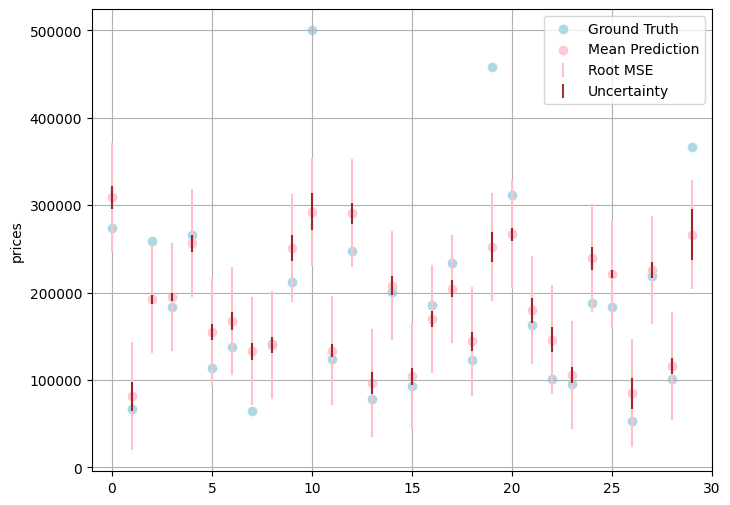

In [143]:
plt.figure(figsize=(8, 6))
plt.xlim(-1,PLOT)
plt.scatter(x_axis, y_plot, color='lightblue', label="Ground Truth")
plt.scatter(x_axis, y_mean_predict.flatten(), color='pink', alpha=0.8, label='Mean Prediction')
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=root_mse, fmt='none', ecolor='pink', label="Root MSE")
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=y_var_predict.flatten(), fmt='none', color='darkred', alpha=0.8, label="Uncertainty")
plt.ylabel('prices')
plt.legend()
plt.grid(True)  # Enable grid for better visualization
plt.show()